In [1]:
using Random, Distributions
#using Pkg; pkg"add Plots@1.2.2"
using PyPlot
#using Plots
using DelimitedFiles
using TickTock
using NPZ

In [2]:

### range 100 and 2000 V/cm
function mu(E, T)         # electron mobility  cm^2/s/V   (kV?)
    E = abs(E)
    a0 = 551.6
    a1 = 7953.7
    a2 = 4440.43
    a3 = 4.29
    a4 = 43.63
    a5 = 0.2053
    T0 = 89
    num = a0 + a1*E+a2*E^(3/2)+a3*E^(5/2)
    den = 1+(a1/a0)*E+a4*E^2+a5*E^3
    return num/den*(T/T0)^(-3/2)
end

### range 350 and 2000 V/cm
### effective electron energy
    
function e_eff(E, T)       #in eV
    E = abs(E)
    b0 = 0.0075
    b1 = 742.9
    b2 = 3269.6
    b3 = 31678.2
    num = b0 + b1*E + b2*E^2
    den = 1 + (b1/b0)*E + b3*E^2
    T1 = 87
    return num/den*(T/T1)
end

function  Dl(E, T)       #cm^2/s
    E = abs(E)
    return mu(E, T)*e_eff(E, T)
end

function Dt(E, T)       #cm^2/s
    E = abs(E)
    kb = 8.617333262145e-5  ## Boltzmann constant in eV/K
    return kb*T*mu(E, T)
end

function p_l(E, T, dt, num)
    sigma = 2*sqrt(Dl(E, T)*dt)
    v_driff = mu(E, T)*E*1e3 #### kV/cm to V/m
    mean = v_driff*dt
    return rand(Normal(mean, sigma), num)
end

function p_t(E, T, dt, num)
    sigma = 2*sqrt(Dt(E, T)*dt)
    mean = 0  
    return rand(Normal(mean, sigma), num)
end


p_t (generic function with 1 method)

In [3]:
function mc_electron(Emag, freq, Eshift,T, dt, tmax, events)
#    start = time.time()
    t = 0: dt: tmax 
    tick()
    z_all = zeros( size(t, 1), events)
    r_all = zeros(size(t, 1), events)
    ei = 1
    while ei < events+1
        i = 1
        z = zeros(size(t, 1))
        r = zeros(size(t, 1))
        phase = rand()
        while i < size(t, 1)
            E = Emag*sin(freq*2*pi*(t[i]+phase))+ Eshift
            dz = p_l(E, T, dt, 1)[1]
            #println(dz)
            dr = p_t(E, T, dt, 1)[1]
            # new_z = z[i, :] + dz
            # new_r = r[i, :] + dr
            z[i+1] = z[i] .+ dz
            r[i+1] = abs(r[i] .+ dr)
            if r[i+1]>1.25
                r[i+1] = 1.25-(r[i+1]-1.25)
            end
            i = i+1
            # if i%500==0:
            #     process = psutil.Process(os.getpid())    
            #     print('Memory use:', process.memory_info().rss/1024**3)  # in G 
        end
        # print(z)
        z_all[:, ei] = z
        r_all[:, ei] = r
        ei = ei + 1 
    end
#    end = time.time()
#    print(events, 'events',len(t), ', times steps' ,', Run time:', end - start, 's')    
#    process = psutil.Process(os.getpid())  
#    print('Memory use:', process.memory_info().rss/1024**3, "G")  # in G
    tock()
    return t, z_all, r_all
    GC.gc()
end

mc_electron (generic function with 1 method)

In [30]:
E = 5e-3  ### kV/cm
Esft = 5e-5
frq = 1e3 ## Hz
T = 130  ## K
dt = 1/frq/15  ##s
tmax = 1e-2
events = 1000
t, z, r =   mc_electron(E, frq, Esft,T, dt, tmax, events) 

┌ Info:  started timer at: 2021-03-22T22:22:36.981
└ @ TickTock /home/alex/.julia/packages/TickTock/RsTHR/src/TickTock.jl:32
┌ Info:            0.1206456s: 120 milliseconds
└ @ TickTock /home/alex/.julia/packages/TickTock/RsTHR/src/TickTock.jl:39


(0.0:6.666666666666667e-5:0.01, [0.0 0.0 … 0.0 0.0; -0.118186 0.102003 … -0.0436689 -0.0851931; … ; -0.0886325 0.187623 … 0.461766 0.121825; -0.118488 0.283514 … 0.483462 0.0521529], [0.0 0.0 … 0.0 0.0; -0.00592545 0.00326607 … 0.0124897 -0.00800224; … ; 0.751573 0.109943 … -0.0473285 0.0870897; 0.762821 0.116941 … -0.0941822 0.108232])

Julia has similar syntax. It is 68x faster than python, use 10x Ram.

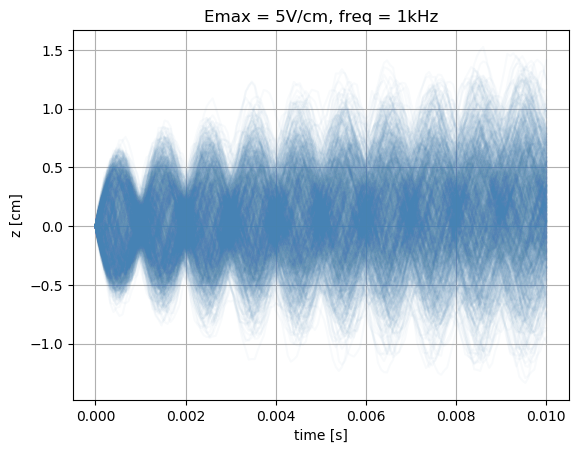

PyObject Text(0.5,1,'Emax = 5V/cm, freq = 1kHz')

In [31]:
zplot = plot(t, z, color=:steelblue , alpha = 0.035) 
grid()
xlabel("time [s]")
ylabel("z [cm]")
title("Emax = 5V/cm, freq = 1kHz")

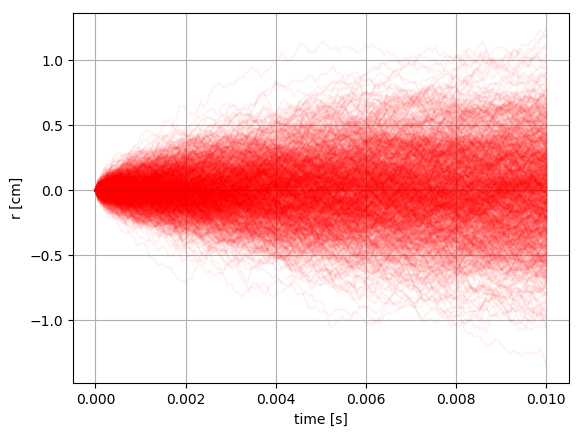

PyObject Text(24,0.5,'r [cm]')

In [32]:
rplot = plot(t, r, color=:red , alpha = 0.05)   
grid()
xlabel("time [s]")
ylabel("r [cm]")


Increase the frequancy.

┌ Info:  started timer at: 2021-03-22T22:24:09.001
└ @ TickTock /home/alex/.julia/packages/TickTock/RsTHR/src/TickTock.jl:32
┌ Info:            1.2063754s: 1 second, 206 milliseconds
└ @ TickTock /home/alex/.julia/packages/TickTock/RsTHR/src/TickTock.jl:39


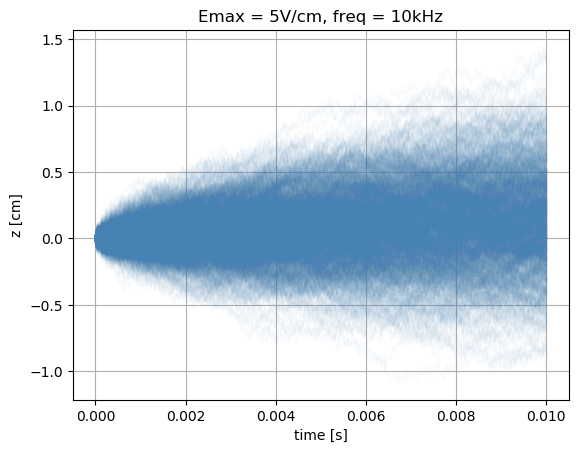

PyObject Text(0.5,1,'Emax = 5V/cm, freq = 10kHz')

In [35]:
E = 5e-3  ### kV/cm
frq = 1e4 ## Hz
Esft = 5e-5
T = 130  ## K
dt = 1/frq/15  ##s
tmax = 1e-2
events = 1000
t, z, r =   mc_electron(E, frq, Esft,T, dt, tmax, events) 
zplot = plot(t, z, color=:steelblue , alpha = 0.035) 
grid()
xlabel("time [s]")
ylabel("z [cm]")
title("Emax = 5V/cm, freq = 10kHz")

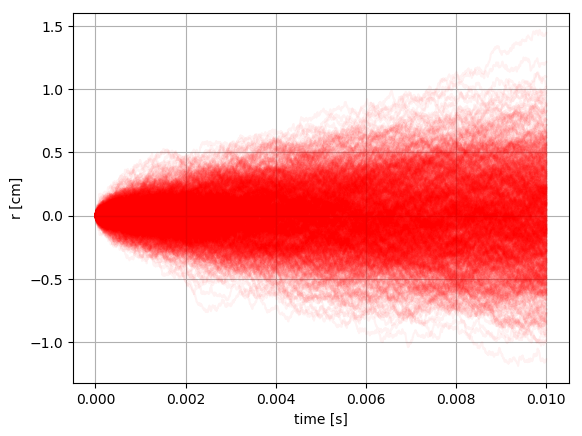

PyObject Text(24,0.5,'r [cm]')

In [36]:
rplot = plot(t, r, color=:red , alpha = 0.05)   
grid()
xlabel("time [s]")
ylabel("r [cm]")

Increase the magnitude of E-field

┌ Info:  started timer at: 2021-03-22T22:25:17.104
└ @ TickTock /home/alex/.julia/packages/TickTock/RsTHR/src/TickTock.jl:32
┌ Info:            0.8205027s: 820 milliseconds
└ @ TickTock /home/alex/.julia/packages/TickTock/RsTHR/src/TickTock.jl:39


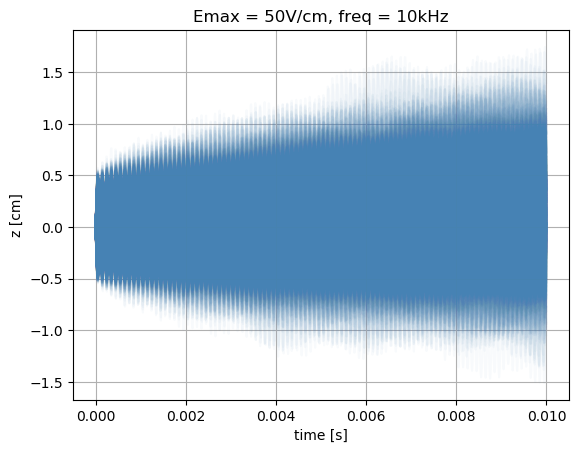

PyObject Text(0.5,1,'Emax = 50V/cm, freq = 10kHz')

In [38]:
E = 5e-2  ### kV/cm
Esft = 5e-5 
frq = 1e4 ## Hz
T = 130  ## K
dt = 1/frq/10  ##s
tmax = 1e-2
events = 1000
t, z, r =   mc_electron(E, frq, Esft, T, dt, tmax, events) 
zplot = plot(t, z, color=:steelblue , alpha = 0.035) 
grid()
xlabel("time [s]")
ylabel("z [cm]")
title("Emax = 50V/cm, freq = 10kHz")

┌ Info:  started timer at: 2021-03-22T23:05:53.253
└ @ TickTock /home/alex/.julia/packages/TickTock/RsTHR/src/TickTock.jl:32
┌ Info:            0.6050256s: 605 milliseconds
└ @ TickTock /home/alex/.julia/packages/TickTock/RsTHR/src/TickTock.jl:39


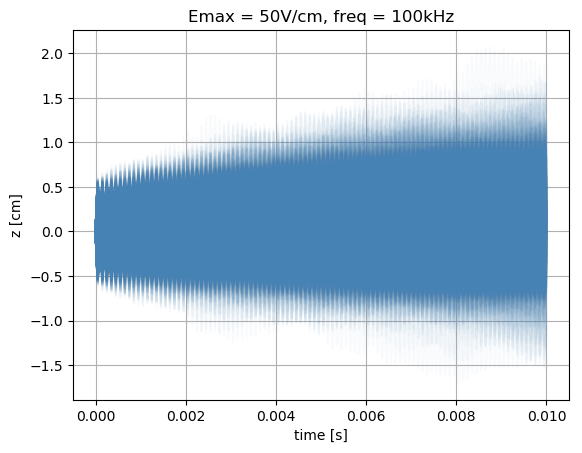

PyObject Text(0.5,1,'Emax = 50V/cm, freq = 100kHz')

In [49]:
E = 5e-2  ### kV/cm
Esft = 5e-5 
frq = 1e3 ## Hz
T = 130  ## K
dt = 1/frq/4  ##s
tmax = 1e-2
events = 1000
t, z, r =   mc_electron(E, frq, Esft,T, dt, tmax, events) 
zplot = plot(t, z, color=:steelblue , alpha = 0.035) 
grid()
xlabel("time [s]")
ylabel("z [cm]")
title("Emax = 50V/cm, freq = 100kHz")

┌ Info:  started timer at: 2021-04-07T22:52:14.78
└ @ TickTock /home/alex/.julia/packages/TickTock/RsTHR/src/TickTock.jl:32
┌ Info:           86.6398679s: 1 minute, 26 seconds, 639 milliseconds
└ @ TickTock /home/alex/.julia/packages/TickTock/RsTHR/src/TickTock.jl:39


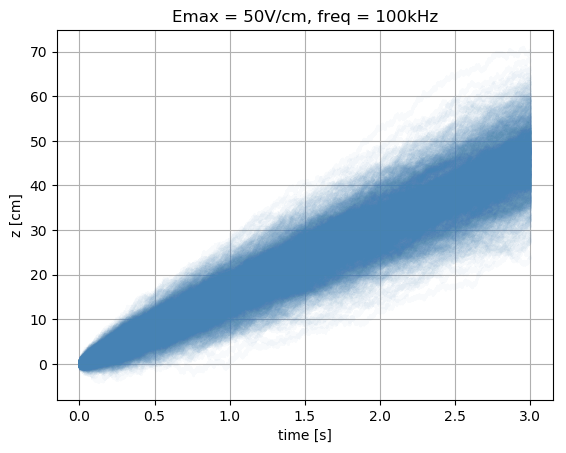

PyObject Text(0.5,1,'Emax = 50V/cm, freq = 100kHz')

In [4]:
GC.gc()
E = 5e-2  ### kV/cm
frq = 1e4 ## Hz
Esft = 5e-5 
T = 130  ## K
dt = 1/frq/4  ##s
tmax = 3
events = 1000
t, z, r =   mc_electron(E, frq, Esft, T, dt, tmax, events) 
plot(t, z, color=:steelblue , alpha = 0.035) 
grid()
xlabel("time [s]")
ylabel("z [cm]")
title("Emax = 50V/cm, freq = 100kHz")

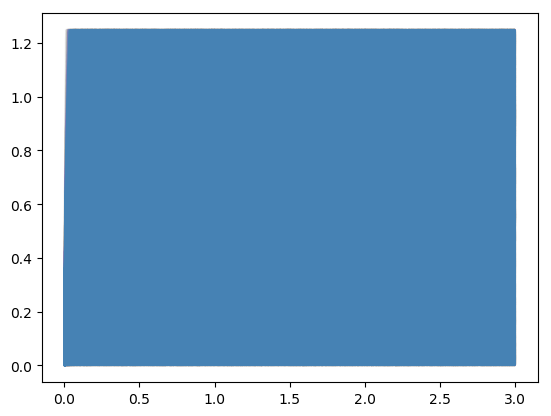

1000-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fae729789e8>
 PyObject <matplotlib.lines.Line2D object at 0x7fae72978ba8>
 PyObject <matplotlib.lines.Line2D object at 0x7fae72978cf8>
 PyObject <matplotlib.lines.Line2D object at 0x7fae72978e48>
 PyObject <matplotlib.lines.Line2D object at 0x7fae72978f98>
 PyObject <matplotlib.lines.Line2D object at 0x7fae72980128>
 PyObject <matplotlib.lines.Line2D object at 0x7fae72980278>
 PyObject <matplotlib.lines.Line2D object at 0x7fae729803c8>
 PyObject <matplotlib.lines.Line2D object at 0x7fae72980518>
 PyObject <matplotlib.lines.Line2D object at 0x7fae72980668>
 PyObject <matplotlib.lines.Line2D object at 0x7fae729807b8>
 PyObject <matplotlib.lines.Line2D object at 0x7fae72980908>
 PyObject <matplotlib.lines.Line2D object at 0x7fae72980a58>
 ⋮                                                          
 PyObject <matplotlib.lines.Line2D object at 0x7fae71e5ff98>
 PyObject <matplotlib.lines.Line2D object at 0

In [12]:
plot(t, r, color=:steelblue , alpha = 0.005) 

In [5]:
GC.gc()

In [6]:
npzwrite("z_0.05mc.npy", z)
npzwrite("r_0.05mc_abs.npy", r)

In [48]:
npzread("z_mc.npy")

400001×500 Array{Float64,2}:
  0.0          0.0           0.0          …   0.0          0.0        
 -0.00140943   0.00490982   -0.0010003        7.88647e-5  -0.00104924 
 -0.00525942   0.00498361    0.00358467      -0.00143813  -0.00309652 
 -0.00622524   0.00145025    0.00447588       0.00383949  -0.00148087 
 -0.00201722  -0.000859096  -8.29786e-5       0.00369422   0.00292534 
 -0.00225749  -0.000249967   0.000165985  …   0.00213214  -4.61495e-5 
 -0.00476072   0.00184096    0.0011381        0.00122103  -0.000888529
 -0.00517032  -2.83193e-5    0.00158769       0.00267276   0.000440776
 -0.00184259  -0.00180364   -0.0029526        0.00519529   0.00137686 
 -0.00272061   0.00235881   -0.00230954       0.00316649   0.00145019 
 -0.00492256   0.00584028    0.00148682   …  -0.00139356  -0.00416998 
 -0.00589584   0.00310002    0.0022006       -0.00162944   0.000495607
 -0.00373351  -0.00205116    0.000783765      0.00309306   0.00367936 
  ⋮                                       ⋱     